In [1]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import colors, cm
from loadmodules import *
import matplotlib.ticker as ticker

In [2]:
simulation_list = [directory for directory in os.listdir('.') if 'lvl4_aa96' in directory]
print(simulation_list)

['Au6_lvl4_aa96_cfefit', 'Au6_lvl4_aa96_cfefit_noconstrain', 'Au6_lvl4_aa96_fixcs', 'Au6_lvl4_aa96_tightconstrain']


In [3]:
simulation_list = [simulation_list[1], simulation_list[0], simulation_list[3]]

In [4]:
cluster_formation_rate = []
age_distribution_surviving = []

nbins = 40
min_range = 0
max_range = 14
for sim in simulation_list:
    sf = load_subfind(127, dir=sim+'/output/')
    s = gadget_readsnap(127, snappath=sim+'/output/', subfind=sf, applytransformationfacs=True, hdf5=True, loadonlyhalo=0, loadonlytype=[4])

    s.calc_sf_indizes(sf)
    rot_matrix = s.select_halo(sf)

    s.data['pos'] *= 1e3 # in kpc
    s.data['mass'] *= 1e10 # change mass to solar masses
    s.data['mclt'] *= 1e10  
    s.data['imcl'] *= 1e10

    s.data['r'] = np.sqrt(np.sum((s.data['pos'])**2, axis=1))

    mask_clusters_initial = (s.data['incl'] > 0 )

    cluster_masses = s.data['mclt'][mask_clusters_initial].flatten()
    init_cluster_masses = s.data['imcl'][mask_clusters_initial].flatten()

    not_empty_clusters = (init_cluster_masses>0)

    cluster_masses = cluster_masses[not_empty_clusters]
    init_cluster_masses = init_cluster_masses[not_empty_clusters]

    print('Simulation: {:s}'.format(sim))
    print('Total number of formed clusters {:d}'.format(s.data['incl'].sum()))
    print('Total number of surviving clusters {:d}'.format(s.data['nclt'].sum()))
    print('Maximum initial number of clusters per star {:d}'.format(s.data['incl'].max()))
    print('Maximum initial mass {:2.2e} Msun'.format(init_cluster_masses.max()))
    print('Maximum present-day mass {:2.2e} Msun'.format(cluster_masses.max()))

    disruption_time = s.data['drpt'][mask_clusters_initial].flatten()
    disruption_time = disruption_time[not_empty_clusters]

    clusters_formtime = np.repeat(s.data['age'][mask_clusters_initial], s.data['incl'][mask_clusters_initial])
    clusters_age = s.cosmology_get_lookback_time_from_a(clusters_formtime, is_flat=True)

    print('Number of disrupted clusters {:d}'.format((disruption_time>0).sum()))

    mask_problematic = s.data['imfc']>1
    print('Problematic stars with clusters {:4d}'.format(mask_problematic.sum()))
    print('That`s {:.3f}% of stars with clusters'.format(mask_problematic.sum()/mask_clusters_initial.sum() * 100))

    dist, bins = np.histogram(clusters_age, bins=nbins, range=[min_range,max_range], weights=init_cluster_masses/((max_range-min_range)/nbins) /1e9)
    cluster_formation_rate.append(dist)
    dist, bins = np.histogram(clusters_age[cluster_masses>0.], bins=nbins, range=[min_range, max_range], density=True)
    age_distribution_surviving.append(dist)

/storage/home/can35/can35007/pylib/gadget_subfind.py:447: H5pyDeprecationWarning: Using astype() as a context manager is deprecated. Slice the returned object instead, like: ds.astype(np.int32)[:10]
  with dset.astype('int64'):
/storage/home/can35/can35007/pylib/gadget_snap.py:730: H5pyDeprecationWarning: Using astype() as a context manager is deprecated. Slice the returned object instead, like: ds.astype(np.int32)[:10]
  with dset.astype('uint64'):


galrad= 0.02128308862447739
Found 1280999 stars.
Simulation: Au6_lvl4_aa96_cfefit_noconstrain
Total number of formed clusters 91998
Total number of surviving clusters 14151
Maximum initial number of clusters per star 6
Maximum initial mass 4.26e+07 Msun
Maximum present-day mass 2.29e+07 Msun
Number of disrupted clusters 77847
Problematic stars with clusters 6235
That`s 7.204% of stars with clusters
galrad= 0.021321217715740207
Found 1562819 stars.
Simulation: Au6_lvl4_aa96_cfefit
Total number of formed clusters 39332
Total number of surviving clusters 3612
Maximum initial number of clusters per star 6
Maximum initial mass 8.67e+07 Msun
Maximum present-day mass 4.37e+07 Msun
Number of disrupted clusters 35720
Problematic stars with clusters 2984
That`s 8.191% of stars with clusters
galrad= 0.02139813154935837
Found 1434190 stars.
Simulation: Au6_lvl4_aa96_tightconstrain
Total number of formed clusters 31438
Total number of surviving clusters 2765
Maximum initial number of clusters per s

In [20]:
def get_redshift(lookbacktime):
    a_test = np.linspace(1e-2,1,500)
    a_analogous = []
    for t in lookbacktime:
        a_analogous.append(a_test[np.absolute(s.cosmology_get_lookback_time_from_a(a_test, is_flat=True) - t).argmin()])
    a_analogous = np.array(a_analogous)
    return 1/a_analogous - 1

/apps/PYTHON/3.7.4-Anaconda3-2019.10/lib/python3.7/site-packages/ipykernel_launcher.py:19: RuntimeWarning: invalid value encountered in true_divide
/apps/PYTHON/3.7.4-Anaconda3-2019.10/lib/python3.7/site-packages/ipykernel_launcher.py:20: RuntimeWarning: invalid value encountered in true_divide


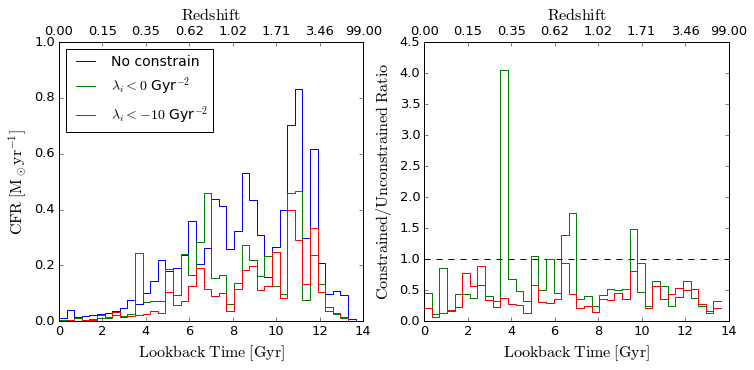

In [21]:
fig, ax = plt.subplots(1,2, figsize=(12,5))

ax[0].step(bins[:-1], cluster_formation_rate[0], where='post', label='No constrain')
ax[0].step(bins[:-1], cluster_formation_rate[1], where='post', c='g', label=r'$\lambda_i < 0$ Gyr$^{-2}$')
ax[0].step(bins[:-1], cluster_formation_rate[2], where='post', c='r', label=r'$\lambda_i <-10$ Gyr$^{-2}$')
ax[0].set_ylabel(r'$\rm{CFR \; [M_\odot yr^{-1}]}$', fontsize=16)
ax[0].set_xlabel(r'$\rm{Lookback \; Time \; [Gyr]}$', fontsize=16)
ax[0].legend(fontsize=14, loc='upper left')
ax[0].tick_params(axis='both', which='major', labelsize=13)
ax[0].set_ylim(0, 1.)
sax = ax[0].twiny()
time_ticks = ax[0].get_xticks()
sax.set_xlim(ax[0].get_xlim())
sax.set_xticks(time_ticks)
sax.set_xticklabels(['{:.2f}'.format(z) for z in get_redshift(time_ticks)])
sax.set_xlabel(r'$\rm Redshift$', fontsize=16)
sax.tick_params(axis='both', which='major', labelsize=13)

ax[1].step(bins[:-1], cluster_formation_rate[1]/cluster_formation_rate[0], where='post', c='g', label=r'$\lambda_i < 0$ Gyr$^{-2}$')
ax[1].step(bins[:-1], cluster_formation_rate[2]/cluster_formation_rate[0], where='post', c='r', label=r'$\lambda_i <-10$ Gyr$^{-2}$')
ax[1].hlines(1, 0, 14, linestyle='--', color='black')
sax = ax[1].twiny()
time_ticks = ax[1].get_xticks()
sax.set_xlim(ax[1].get_xlim())
sax.set_xticks(time_ticks)
sax.set_xticklabels(['{:.2f}'.format(z) for z in get_redshift(time_ticks)])
sax.set_xlabel(r'$\rm Redshift$', fontsize=16)
sax.tick_params(axis='both', which='major', labelsize=13)
ax[1].set_ylabel(r'$\rm{Constrained/Unconstrained \; Ratio}$', fontsize=16)
ax[1].set_xlabel(r'$\rm{Lookback \; Time \; [Gyr]}$', fontsize=16)
# ax[1].legend(fontsize=14, loc='upper right')
ax[1].tick_params(axis='both', which='major', labelsize=13)
# plt.savefig('plots/cluster_formation_rate_ratio_aa96_cfefit.pdf')

/apps/PYTHON/3.7.4-Anaconda3-2019.10/lib/python3.7/site-packages/ipykernel_launcher.py:19: RuntimeWarning: invalid value encountered in true_divide
/apps/PYTHON/3.7.4-Anaconda3-2019.10/lib/python3.7/site-packages/ipykernel_launcher.py:20: RuntimeWarning: invalid value encountered in true_divide


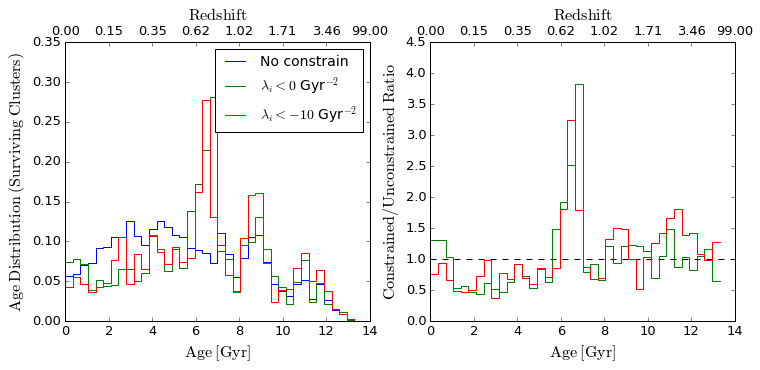

In [22]:
fig, ax = plt.subplots(1,2, figsize=(12,5))

ax[0].step(bins[:-1], age_distribution_surviving[0], where='post', label='No constrain')
ax[0].step(bins[:-1], age_distribution_surviving[1], where='post', c='g', label=r'$\lambda_i < 0$ Gyr$^{-2}$')
ax[0].step(bins[:-1], age_distribution_surviving[2], where='post', c='r', label=r'$\lambda_i <-10$ Gyr$^{-2}$')
ax[0].set_ylabel(r'$\rm{Age \; Distribution \; (Surviving \;Clusters)}$', fontsize=16)
ax[0].set_xlabel(r'$\rm{Age \; [Gyr]}$', fontsize=16)
ax[0].legend(fontsize=14, loc='upper right')
ax[0].tick_params(axis='both', which='major', labelsize=13)
ax[0].set_ylim(0, 0.35)
sax = ax[0].twiny()
time_ticks = ax[0].get_xticks()
sax.set_xlim(ax[0].get_xlim())
sax.set_xticks(time_ticks)
sax.set_xticklabels(['{:.2f}'.format(z) for z in get_redshift(time_ticks)])
sax.set_xlabel(r'$\rm Redshift$', fontsize=16)
sax.tick_params(axis='both', which='major', labelsize=13)

ax[1].step(bins[:-1], age_distribution_surviving[1]/age_distribution_surviving[0], where='post', c='g', label=r'$\lambda_i < 0$ Gyr$^{-2}$')
ax[1].step(bins[:-1], age_distribution_surviving[2]/age_distribution_surviving[0], where='post', c='r', label=r'$\lambda_i <-10$ Gyr$^{-2}$')
ax[1].hlines(1, 0, 14, linestyle='--', color='black')
ax[1].set_ylim(0, 4.5)
sax = ax[1].twiny()
time_ticks = ax[1].get_xticks()
sax.set_xlim(ax[1].get_xlim())
sax.set_xticks(time_ticks)
sax.set_xticklabels(['{:.2f}'.format(z) for z in get_redshift(time_ticks)])
sax.set_xlabel(r'$\rm Redshift$', fontsize=16)
sax.tick_params(axis='both', which='major', labelsize=13)
# ax[1].legend(fontsize=14, loc='upper right')
ax[1].set_ylabel(r'$\rm{Constrained/Unconstrained \; Ratio}$', fontsize=16)
ax[1].set_xlabel(r'$\rm{Age \; [Gyr]}$', fontsize=16)
ax[1].tick_params(axis='both', which='major', labelsize=13)
# plt.savefig('plots/age_distribution_ratio_aa96_cfefit.pdf')